# Static correlation functions

We will consider classical systems composed of $N$ particles interacting via a pairwise potential $u(r)$. One first model is based on the Lennard-Jones potential

$$
u(r) = 4\epsilon \left[(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6\right]
$$

which provides a good description of the properties of nobel gases (Ar, Xe, Ne). In addition, we will cosnider the so-called Gaussian core model, in which particles interact via a Gaussian potential

$$
u(r) = \epsilon \exp{[- (r/\sigma)^2]}
$$

The Gaussian core model describes the effective interactions between dilute linear polymer chains in good solvent (note that \epsilon is considered here as a constant, i.e., it does not scale with $k_B T$).

We will analyze several "trajectories" obtained from molecular dynamics simulations performed in the microcanonical ensemble, at different density and total energy conditions. Energies and lengths are measured in units of $\epsilon$ and $\sigma$, respectively. The following values provide a good description of the properties of Argon using the Lennard-Jones potential: $\epsilon\approx 120 K$ and $\sigma \approx 3.4\times 10^{-10}m$.

Our goal is to characterize the thermodynamic and structural properties of the system using static correlation functions. Statistical averages will be carried out by averaging the quantities of interest over time. To this end, we will the [atooms](https://framagit.org/atooms/atooms/tree/master) python package and its companion [postprocessing](https://framagit.org/atooms/postprocessing/tree/master) package, which will help us analyzing the trajectories in a simple, pythonic way.

Should you need some more info about to the workings of `atooms` and `postprocessing`, which we will use for trajectory analysis, [this tutorial](https://coulomb.umontpellier.fr/perso/daniele.coslovich/atooms/) and [this other tutorial](https://coulomb.umontpellier.fr/perso/daniele.coslovich/pp_notebook/) might be useful.  

First off, we download a sample trajectory file (in so-called xyz format) and store it in the current directory.

In [ ]:
from atooms.core.utils import download

download('https://framagit.org/atooms/atooms/raw/master/data/trajectory.xyz', '.')

Trajectories are list-like objects that can be iterated upon. Each frame of the trajectory contains a `System`, which is composed by a list of `Particle` objects and a simulation `Cell` (periodic boundary conditions were used in the used during the simulation). Type `help(system)` to get the full list of its properties.

In [ ]:
from atooms.trajectory import Trajectory

# Open the trajectory and read the system at the last frame
with Trajectory('trajectory.xyz') as th:
    system = th[-1]

# Count how many particles we have and print the side of the simulation cell
print(len(system.particle))
print(system.cell.side)

# Print the density and kinetic temperature at the last frame
print(system.density)
print(system.temperature)

We have a look at the spatial structure of the system using the [py3dmol](https://pypi.org/project/py3Dmol/) visualization package, which `atooms` can use as a visualization backend

In [ ]:
system.show('3dmol')

Finally, let's use some `postprocessing` tools to compute static correlation functions (here the radial distribution function $g(r)$) and plot them

In [ ]:
import atooms.postprocessing as pp
import matplotlib.pyplot as plt

gr = pp.RadialDistributionFunction('trajectory.xyz')
gr.compute()
plt.plot(gr.grid, gr.value)

Similarly, we can compute the static structure factor $S(k)$

In [ ]:
# Use the nk parameter to change the number of wave-vectors 
# to carry out the spherical average
# nk=200 should be fine
sk = pp.StructureFactor('trajectory.xyz', nk=200)
sk.compute()
plt.plot(sk.grid, sk.value)

**Exercise 1**: *trajectory analysis*

Download and analyze the following three trajectories for a single-component Lennard-Jones system:

- https://moodle2.units.it/pluginfile.php/367456/mod_folder/content/0/lj_1.xyz
- https://moodle2.units.it/pluginfile.php/367456/mod_folder/content/0/lj_2.xyz
- https://moodle2.units.it/pluginfile.php/367456/mod_folder/content/0/lj_3.xyz

For each of them, visualize the system at the initial and final frame, extract information about the thermodynamic state of the system and its structure. 

As a reference, here is the phase diagram of the LJ system in the $\rho,T$ diagram (source: Johnson et al. Mol. Phys. 78, 591 (1993))

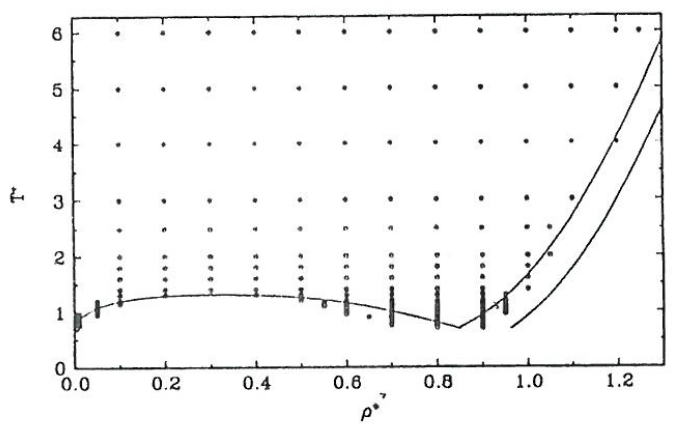

Here are a few questions to guide you in the analysis:
- Which phase is the system in?
- How do the $g(r)$ and $S(k)$ look like?
- How would you tell if the system is at equilibrium or not?

**Exercise 2**: *local structure*
    
- Estimate the coordination number $N_1$ of the Lennard-Jones liquid from the integral of the $g(r)$ over the first shell of neighbors (pick up the "right" trajectory from the ones above).
- Extract a `system` from a trajectory frame and use the code below to visualize the first coordination shell of particle `0`. Adapt the code to visualize the second shell of neighbors. 

In [ ]:
import numpy
from atooms.system import System

# Cutoff distance for the first shell of neighbors
r_1 = 2.0

# Gather neighbors in the first coordination shell
particle = system.particle[0]
shell = System()
for other in system.particle:
    if other is not particle:
        r = numpy.sum(particle.distance(other, system.cell)**2)  
        if r < r_1:
            neighbor = other.nearest_image(particle, system.cell, copy=True)
            shell.particle.append(neighbor)

# Now center the cluster at the origin for better visualization
for neighbor in shell.particle:
    neighbor.position -= particle.position

# Show the shell of neighbors
shell.show('3dmol')

**Exercise 3**: *thermodynamic properties*

Use the expression seen in class to estimate the isothermal compressibility $\chi_T$ of the Lennard-Jones liquid from the $k\rightarrow 0$ limit of the structure factor $S(k)$. Convert the result in Argon units and comment.

**Exercise 4**: *static correlation length*

To see how far local density fluctuations are correlated in a liquid, estimate the microscopic correlation length $\xi_0$ from the decay of the long range oscillations of the total distribution function $h(r) = g(r) - 1$. To do this, plot $|\log(h(r))|$ vs $r$ and "fit" the envelope of the peaks to the following functional form
$$
h(r) \sim \frac{\exp(-r/\xi_0)}{r}
$$

*Hint*: do not try to fit the envelope with `curve_fit()`, it is enough to adjust the parameter $\xi_0$ by hand!

**Exercise 5**: *Gaussian core model*

Download and analyze the following trajectories for the Gaussian core model

- https://moodle2.units.it/pluginfile.php/368787/mod_folder/content/0/gcm_rho0.1.xyz
- https://moodle2.units.it/pluginfile.php/368787/mod_folder/content/0/gcm_rho0.2.xyz
- https://moodle2.units.it/pluginfile.php/368787/mod_folder/content/0/gcm_rho0.4.xyz
- https://moodle2.units.it/pluginfile.php/368787/mod_folder/content/0/gcm_rho1.0.xyz
- https://moodle2.units.it/pluginfile.php/368787/mod_folder/content/0/gcm_rho2.0.xyz

The temperature is constant $T\approx 0.01$ (in reduced units) and the density is varied from $\rho=0.1 to 2.0$. Compute the and plot $g(r)$ as a function of density. Which peculiar features do you notice? How would you describe the bevahior of the $g(r)$ at high density? For reference, here is the phase diagram computed by Lang et al. J. Phys.: Condens. Matter 12, 5087 (2000) 

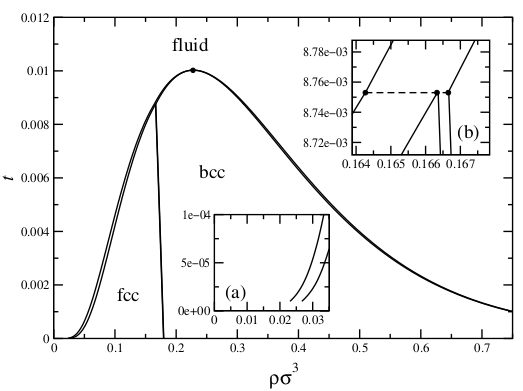